In [1]:
%run EUVIP_1_defaults.ipynb

Range of spatial frequencies:  [ 0.618   0.382   0.2361  0.1459  0.0902  0.0557  0.0344  0.0213]
Range of angles (in degrees):  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]
Final sparseness in the representation = 0.0026041666666666665
Final sparseness in the pyramid = 0.375


## Running simulations on a set of natural images

In [2]:
%cd -q ../test/

In [3]:
%%writefile ../test/experiment_sparseness.py
# -*- coding: utf8 -*-
from __future__ import division, print_function
"""

Exploring the sparseness of coefficients in the SparseEdges framework.

"""
import sys
experiment = sys.argv[1]
parameter_file = sys.argv[2]
name_database = sys.argv[3]
N_image = int(sys.argv[4])
print('N_image = ', N_image)
N = int(sys.argv[5])
do_linear = (sys.argv[6] == 'True')

import numpy as np
from SparseEdges import SparseEdges
mps = []
for name_database in [name_database]:
    mp = SparseEdges(parameter_file)
    mp.pe.datapath = 'database/'
    mp.pe.N_image = N_image
    mp.pe.do_mask = True
    mp.pe.N = N
    mp.init()
    # normal experiment
    imageslist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
    mps.append(mp)
    # control experiment
    if do_linear:
        mp.pe.MP_alpha = np.inf
        mp.init()
        imageslist, edgeslist, RMSE = mp.process(exp=experiment + '_linear', name_database=name_database)
        mps.append(mp)


Overwriting ../test/experiment_sparseness.py


In [4]:
experiment_folder = experiment = 'EUVIP-sparseness'

cluster = True
cluster = False

if cluster:
    try:
        from INT_cluster import Frioul
        k = Frioul(experiment_folder, N_jobs = 64)
    except Exception:
        cluster = False
else:
    def run_cmd(cmd, doit=True):
        import subprocess
        print ('⚡︎ Running ⚡︎ ', cmd)
        if doit:
            stdout = subprocess.check_output([cmd], shell=True)
            return stdout.decode()#.splitlines()


do_update = True
do_update = False

do_cleanup = True
do_cleanup = False

do_run = True
do_run = False

# update
if cluster and do_update:
    k.do_update()
    
# clean-up
if cluster and do_cleanup:
    for cmd in [
        #"rm -fr results data_cache ",
        #"find . -name *sparselets* -exec rm -fr {} \\;",
        "find . -name *lock* -exec rm -fr {} \\;",
        #"touch frioul; rm frioul* ",
        ]:
        print(k.run_on_cluster(cmd))

# preparing
if do_run:
    # RUNNING
    if cluster: k.push_to_cluster(source="{../test/results,../test/data_cache,../test/experiment_sparseness.py,../database}")

    args = 'experiment_sparseness.py {experiment} {parameter_file} {name_database} {N_image} {N} {do_linear} '.format(
            experiment=experiment, parameter_file=parameter_file, 
            name_database=name_database, N_image=N_image, N=N, do_linear=do_linear)

    if cluster:
        fullcmd = 'ipython {args}'.format(args=args)
        for cmd in [
            "frioul_batch  -M {N_jobs} '{fullcmd}' ".format(N_jobs=k.N_jobs, fullcmd=fullcmd), 
            "frioul_list_jobs -v |grep job_array_id |uniq -c",
                    ]:
            print(k.run_on_cluster(cmd))
    else:
        fullcmd = 'ipython3 {args}'.format(args=args)
        run_cmd (fullcmd)

In [5]:
# GETTING the data
import time, os
if cluster:
    while True:    
        print(k.pull_from_cluster())
        print(k.run_on_cluster("tail -n 10 {}".format(os.path.join(k.PATH, 'debug.log'))))
        print(k.run_on_cluster("frioul_list_jobs -v |grep job_array_id |uniq -c"))
        locks = k.run_cmd ("find . -name *lock -exec ls -l {} \;")
        print(locks)
        if len(locks) == 0: break
        time.sleep(100)    

## Analysing results


First, we retrieve edges from a prior edge extraction

In [6]:
%run experiment_sparseness.py EUVIP-sparseness https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py serre07_distractors 100 4096 True 

N_image =  100


In [7]:
imageslist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)

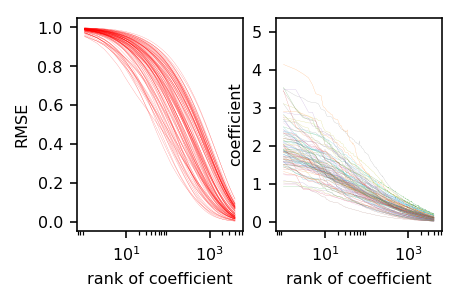

In [8]:
fig, [A, B] = plt.subplots(1, 2, figsize=(fig_width, fig_width/1.618), subplot_kw={'axisbg':'w'})
A.set_color_cycle(np.array([[1., 0., 0.]]))
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
RMSE /= RMSE[:, 0][:, np.newaxis]
#print( RMSE.shape, edgeslist.shape)
value = edgeslist[4, ...]
#value /= value[0, :][np.newaxis, :]
value /= RMSE[:, 0][np.newaxis, :]

B.semilogx( value, alpha=.7, lw=.1)

A.semilogx( RMSE.T, alpha=.7, lw=.1)
for ax in [A,B]:
    ax.set_xlabel('rank of coefficient')
    ax.axis('tight')
_ = A.set_ylabel('RMSE')
_ = B.set_ylabel('coefficient')


#plt.locator_params(axis = 'x', nbins = 5)
#plt.locator_params(axis = 'y', nbins = 5)
mp.savefig(fig, experiment + '_raw', figpath = '../docs/');

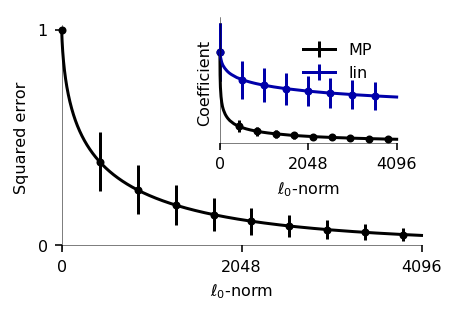

In [9]:
#fig = plt.figure(figsize=(fig_width, fig_width/1.618))
fig = plt.figure(figsize=(fig_width, fig_width/1.5))

if do_linear:
    fig, ax, inset = mp.plot(mps=[mp]*2, experiments=[experiment, experiment + '_linear'], databases=[name_database]*2, fig=fig, 
                  color=[0., 0., 1.], scale=False, labels=['MP', 'lin'])
else:
    fig, ax, inset = mp.plot(mps=[mp], experiments=[experiment], databases=[name_database], fig=fig, 
                  color=[0., 0., 1.], scale=False, labels=['MP'])
    
ax.set_yticks([0, 1.])            
inset.set_yticks([])            
ax.set_xticks([])
ax.set_xticks([0, 2048, 4096])            
inset.set_xticks([0, 2048, 4096])            

mp.savefig(fig, experiment + '_raw_inset', figpath = '../docs/');

In [10]:
%cd -q ../notebooks/